### Extension A - Deprivation Graphs

This analysis was specifically requested by Laura Lloyd-Braff of the WHO. It aims to identify, by district, where deprivation is worst. We define deprivation as the headcount of population that does not have access to a given service within an appropriate threshold. 

This script requires the zonal statistics block in 'Step 4 - Generate Results' to have already been run as it takes a zonal statistics .csv as an input. 

Import the usual suspects

In [117]:
import pandas as pd
import os, sys
sys.path.append(r'C:\Users\charl\Documents\GitHub\GOST_PublicGoods\GOSTNets\GOSTNets')
sys.path.append(r'C:\Users\charl\Documents\GitHub\GOST')
import GOSTnet as gn
import importlib
import geopandas as gpd
import rasterio as rt
from rasterio import features
from shapely.wkt import loads
import numpy as np
import networkx as nx
from shapely.geometry import box, Point, Polygon
import warnings
import seaborn as sns
import glob2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

Here, we define our thresholds, in minutes, for acceptable access to a service, as well as the number of districts to show in each graph.

In [29]:
# path to input .csvs. We are expecting one .csv per service in the thresholds dictionary.
pth = r'C:\Users\charl\Documents\GOST\Yemen\output_layers\Round 3\Images\Vulnerability Matrix + Accessibility\Access to Services'

thresholds = {'Antenatal':60,
             'BEmONC':60,
             'CEmONC':120,
             'Emergency_Surgery':120,
             'Immunizations':60,
             'Int_Outreach':60,
             'Malnutrition':60,
             'Under_5':60}

# Plot Top 30
length = 30 

In this block we build a list, called 'csvs', of all of the .csv zonal stats files we want to build a graph for. 

In [30]:
Q = glob2.glob(pth+r'\**')

csvs = []
for q in Q:
    if q[-4:] == '.csv':
        csvs.append(q)

Now, we move through each of our .csvs, and generate a horizontal bar chart for each. We rank the districts by the headcount of population that lacks access at the relevant threshold defined in 'thresholds'.

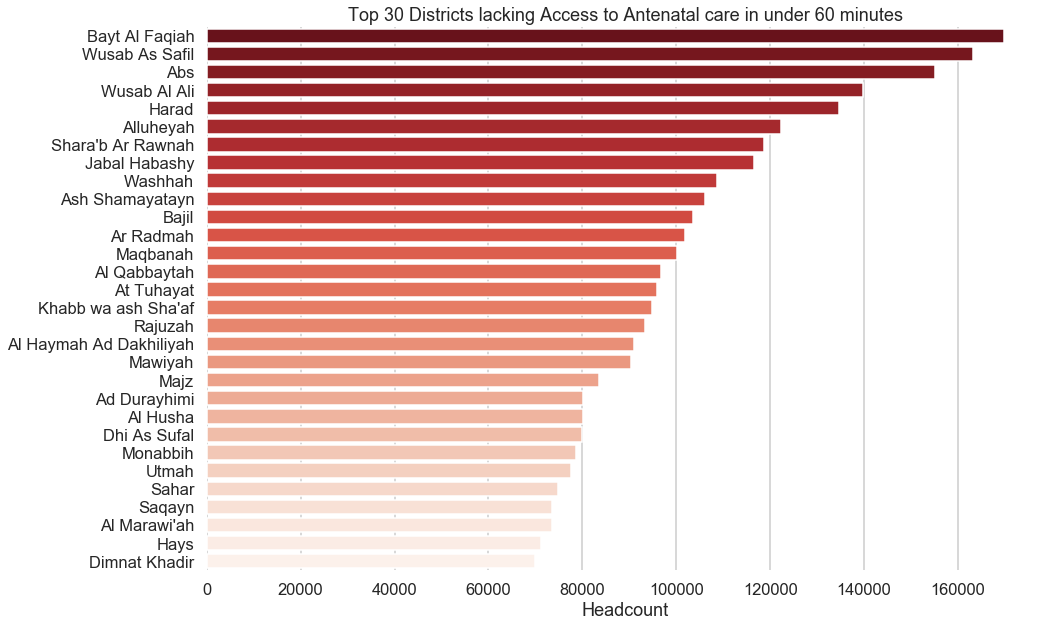

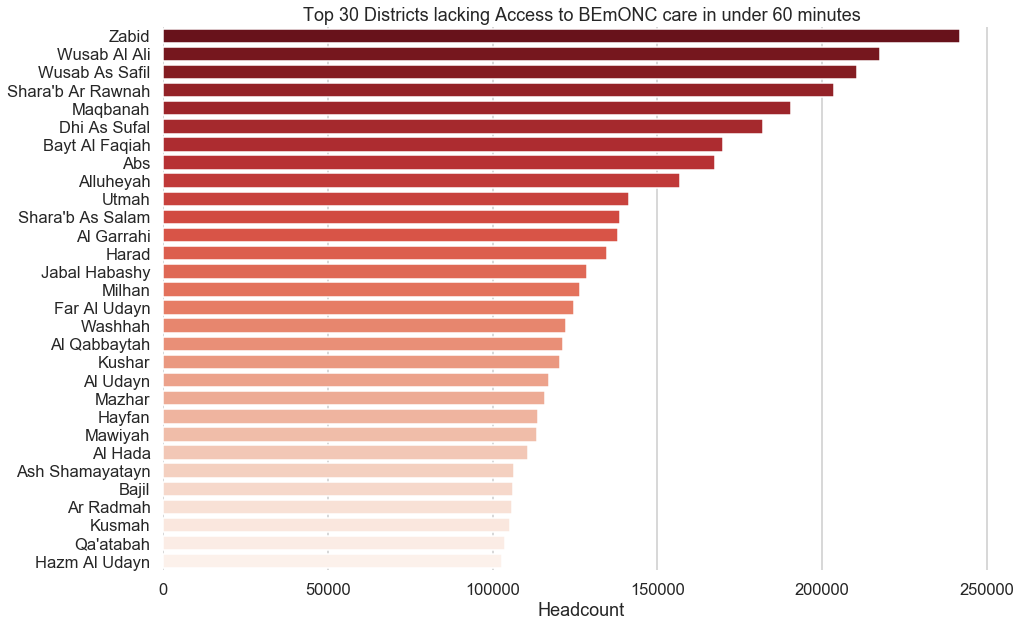

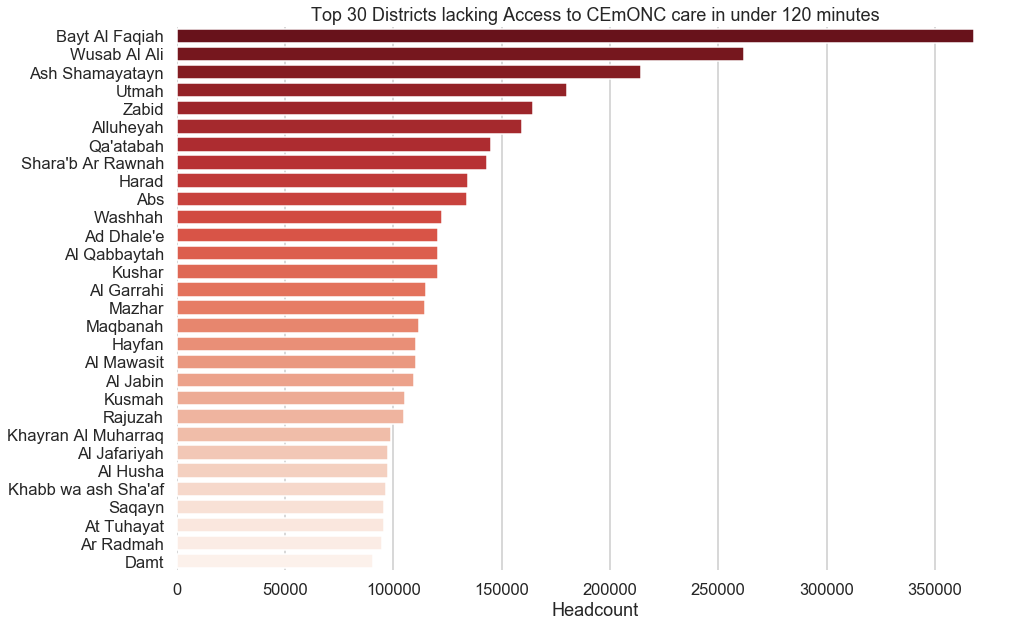

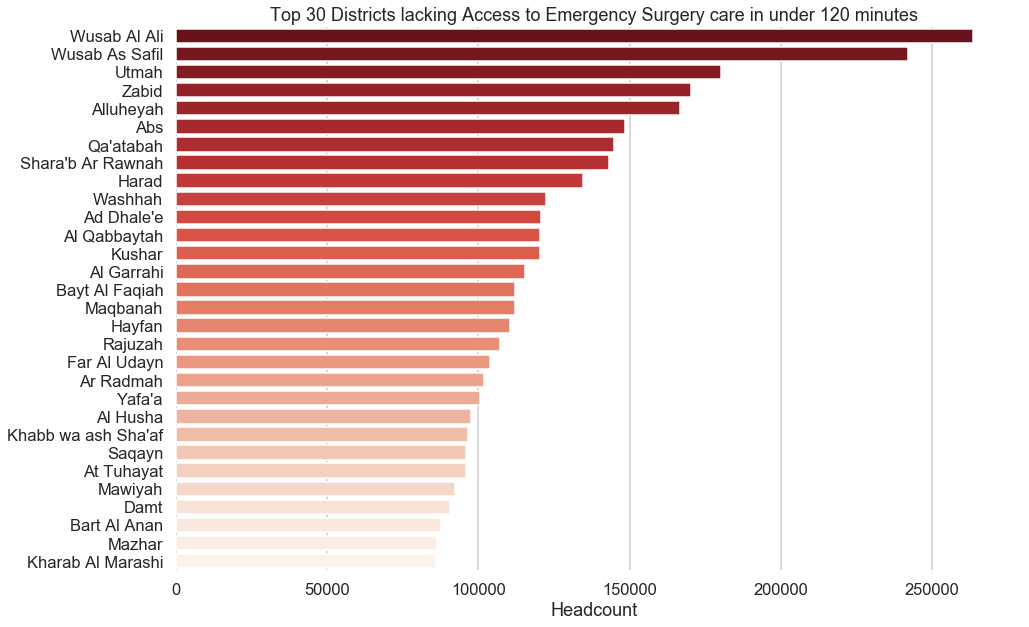

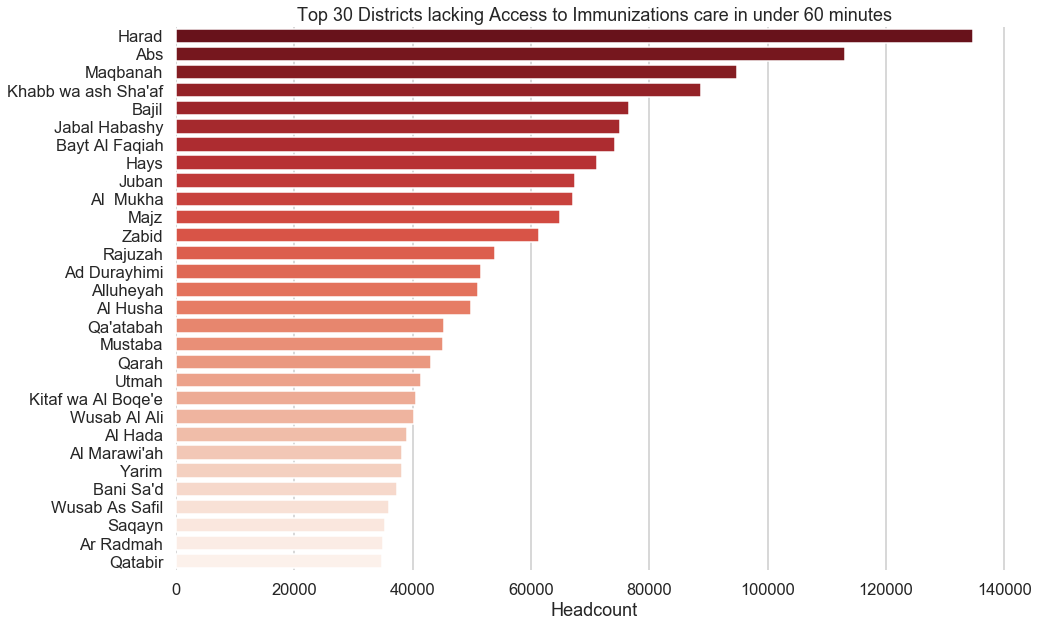

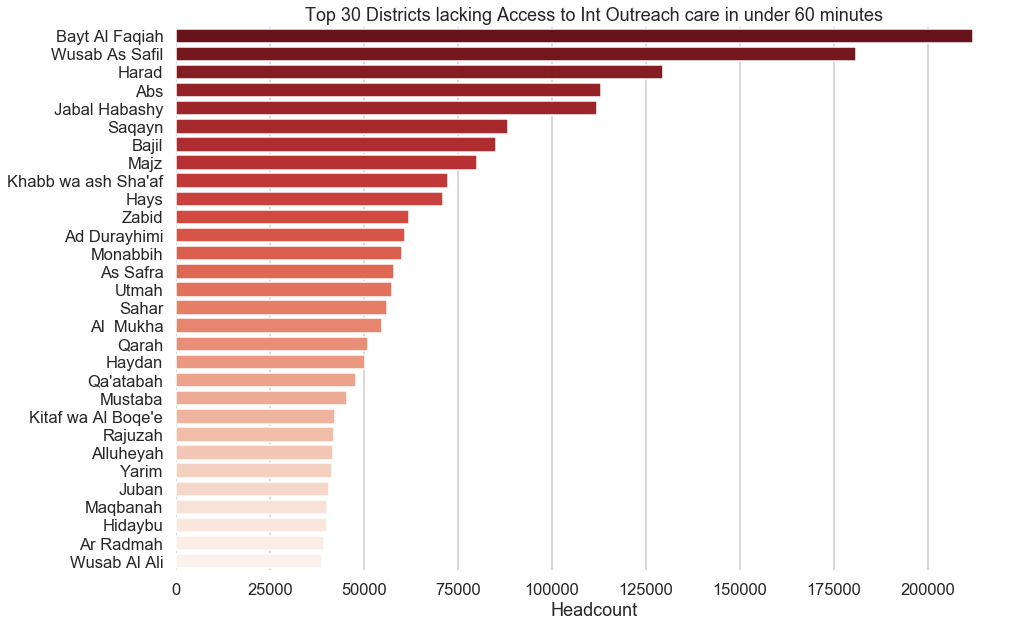

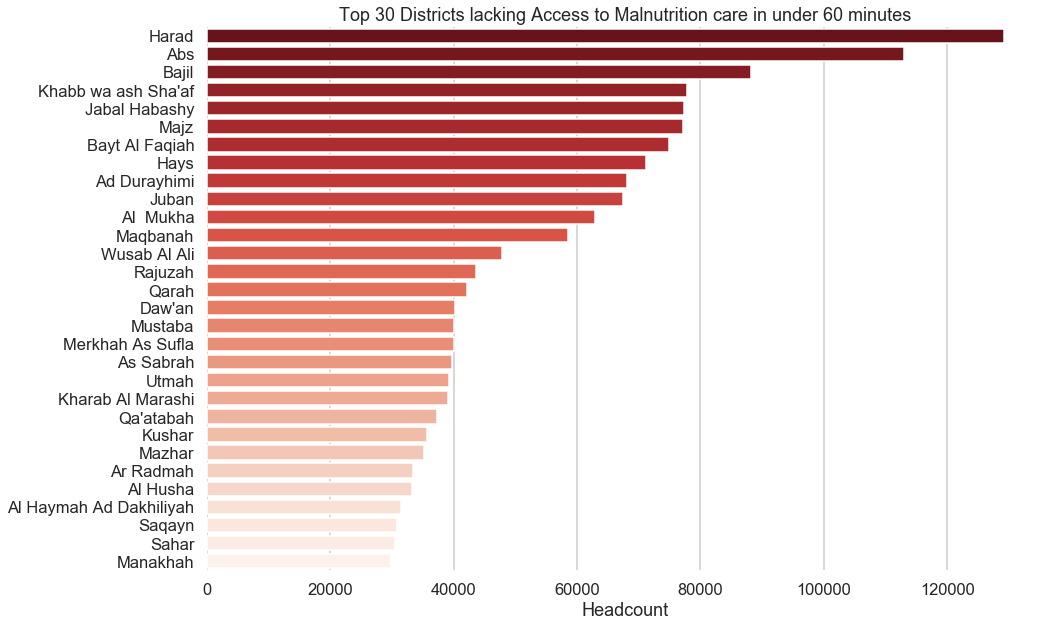

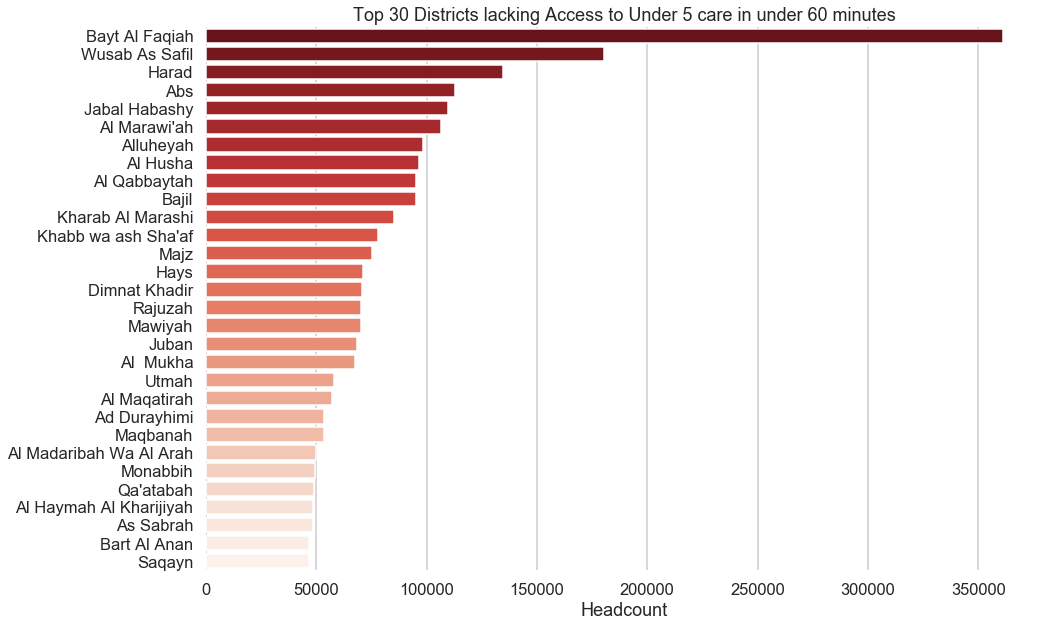

In [78]:
all_deps = []

for csv in csvs:
    
    # we define 'service' as the name of the service we are looking at - it is baked into the .csv name. 
    service = (csv.split('\\')[-1].split('_')[3:-4])
    
    # if it is more than one word, e.g. Emergency Surgery, we add an underscore ('Emergency_Surgery')
    if len(service) == 1:
        service = service[0]
    else:
        service = '{}_{}'.format(service[0],service[1])
        
    # Zonal stats files will have columns beginning with 'iso', denoting the head of population isolated at that 
    # threshold time
    selected_col = 'iso_{}'.format(thresholds[service])
    
    # we read in the csv for this service
    df = pd.read_csv(csv)
    
    # we rank it
    df = df.sort_values(by = selected_col, ascending = False)
    
    # we subset it to just the district name and the value
    df = df[['NAME_2',selected_col]]
    df_save = df.copy()
    
    # we keep only the number of results defined by 'length' - here, 30
    df = df[:length]
    
    # we use Seaborn to set the general style as whitegrid
    sns.set(style="whitegrid", context="talk")
    
    # we want a 1x1 size canvas
    f, ax1 = plt.subplots(1, 1, figsize=(15, 10), sharex=True)
    
    # we use seaborn to plot onto this canvas a barplot, in red, with x = isolated headcount and y = district name
    G = sns.barplot(x=selected_col, y='NAME_2', data = df, palette="Reds_r", ax=ax1)
    
    # we add titles
    titl = "Top {} Districts lacking Access to {} care in under {} minutes".format(length, 
                                                                                          service.replace('_',' '), 
                                                                                          thresholds[service])
    ax1.set_title(titl)
    
    # we add x labels, and despine the axes
    ax1.set(ylabel="",xlabel="Headcount")
    sns.despine(left=True, bottom=True)
    
    # we set a save path, and save our graphs there
    save_pth = r'C:\Users\charl\Documents\GOST\Yemen\output_layers\Round 3\Images\Deprivation (Laura)'
    fig = G.get_figure()
    fig.savefig(os.path.join(save_pth, titl+'.png'), bbox_inches = "tight")
    
    # we add the DataFrame to a list, all_deps, for use in working out total deprivation
    new_name = {selected_col:'{}_iso_{}'.format(service, thresholds[service])}
    df_save = df_save.rename(mapper = new_name, axis = 1)
    all_deps.append(df_save.set_index('NAME_2'))

Using the DataFrames collected in list object all_deps in the previous stage, we generate a single DataFrame which has the headcount isolated in each district for the threshold relevant to that medical service - e.g. 120 minutes for Emergency Service, or 60 for antenatal care. 

In [141]:
Q = all_deps[0]
for i in all_deps[1:]:
    Q = Q.join(i)
Q = Q.drop('Int_Outreach_iso_60', axis = 1)

# IMPORTANT - total deprivation is the sum of the headcount lacking access to each service at their relevant time thresholds. 
# IMPORTANT - Total Deprivation != Population !!!!
Q['Total_Deprivation'] = Q.sum(axis = 1)
Q = Q.sort_values(by = 'Total_Deprivation', ascending = False)

At this point, Q should look like this:

In [142]:
Q

,Antenatal_iso_60,BEmONC_iso_60,CEmONC_iso_120,Emergency_Surgery_iso_120,Immunizations_iso_60,Malnutrition_iso_60,Under_5_iso_60,Total_Deprivation
NAME_2,,,,,,,,
Bayt Al Faqiah,169814.0,169814.0,367914.0,112106.0,74199.0,74884.0,361233.0,1329964.0
Wusab Al Ali,139883.0,217644.0,261819.0,263516.0,40245.0,47856.0,38750.0,1009713.0
Abs,155151.0,167575.0,133869.0,148632.0,113152.0,112984.0,112984.0,944347.0
Harad,134719.0,134719.0,134719.0,134719.0,134719.0,129180.0,134719.0,937494.0
Wusab As Safil,163203.0,210719.0,72690.0,242167.0,36053.0,13221.0,180479.0,918532.0
Alluheyah,122275.0,156905.0,159239.0,166784.0,50994.0,22568.0,98224.0,776989.0
Maqbanah,100151.0,190658.0,112102.0,112102.0,94873.0,58468.0,53342.0,721696.0
Zabid,51493.0,241958.0,164297.0,170330.0,61295.0,16611.0,11870.0,717854.0
Utmah,77612.0,141298.0,180120.0,180120.0,41395.0,39238.0,57992.0,717775.0


Where a column has a 0, that means all of the population in that district has access within the recommended times. 

We want to build a single graph which shows our 'composite index' of deprivation. This is a crude indicator of whihc district, overall, has the most deprivation. 

In this graph, we effectively 'stack' the bar charts from the previous stage. That is - if a person lacks access to three services within those threshold times, they are counted three times (they show up in three separate parts of the stacked column). A person lacking access to all 7 services within the recommended access times is therefore counted as '7'; a person who has access to all services but one is counted once. 

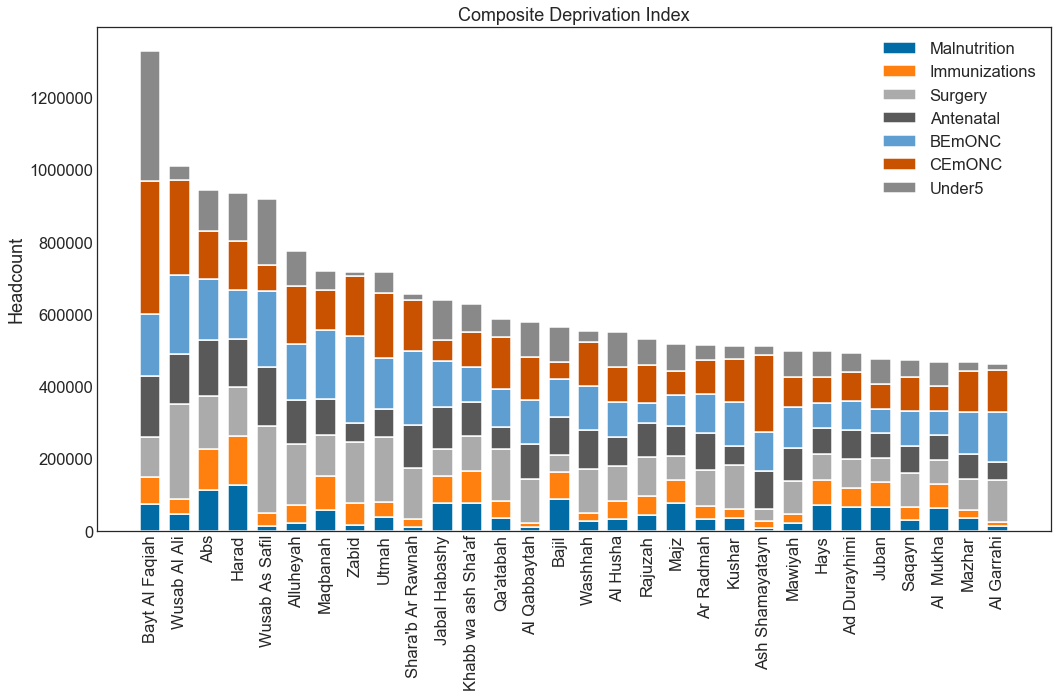

In [148]:
#mpl.rcParams.update(mpl.rcParamsDefault)

# set the color scheme
i = 'tableau-colorblind10'
    
# keep only the top 30 districts by total deprivation
df = Q[:length]

# generate the basic MatPlotLib objects
fig, ax = plt.subplots()
plt.style.use(i)
N = length

# pick out the 7 services we care about
Malnutrition = df['Malnutrition_iso_60']
Immunizations = df['Immunizations_iso_60']
Surgery = df['Emergency_Surgery_iso_120']
Antenatal = df['Antenatal_iso_60']
BEmONC = df['BEmONC_iso_60']
CEmONC = df['CEmONC_iso_120']
Under5 = df['Under_5_iso_60']

ind = np.arange(N)    # the x locations for the groups
width = 0.7     # the width of the bars: can also be len(x) sequence

# Here we are stacking the bars on top of one another. Only p1, the first bar, has no argument for 'bottom' - otherwise, 
# each successive series takes the sum of the previous bars as the place to start plotting that bar.
p1 = plt.bar(ind, Malnutrition, width)
p2 = plt.bar(ind, Immunizations, width,bottom=Malnutrition)
p3 = plt.bar(ind, Surgery, width,bottom=Immunizations+Malnutrition)
p4 = plt.bar(ind, Antenatal, width, bottom=Surgery+Malnutrition+Immunizations)
p5 = plt.bar(ind, BEmONC, width, bottom=Antenatal+Surgery+Malnutrition+Immunizations)
p6 = plt.bar(ind, CEmONC, width, bottom=BEmONC+Antenatal+Surgery+Malnutrition+Immunizations)
p7 = plt.bar(ind, Under5, width, bottom=CEmONC+BEmONC+Antenatal+Surgery+Malnutrition+Immunizations)

# y labels
plt.ylabel('Headcount')

# titles
plt.title('Composite Deprivation Index')

# ticks
plt.xticks(ind, (df.index), rotation = 90)
plt.yticks()

# Here we resize our plot, remove scientific notation for the y-axis, and add a legemnd
fig = plt.gcf()
fig.set_size_inches(15, 10)
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ('Malnutrition', 'Immunizations','Surgery','Antenatal','BEmONC','CEmONC','Under5'))

# we use .tight_layout to add some white space around our graph
plt.tight_layout(pad=1, w_pad=1, h_pad=2.0)

# finally, we save down our final graph. 
bp = r'C:\Users\charl\Documents\GOST\Yemen\output_layers\Round 3\Images\Deprivation (Laura)'
plt.savefig(os.path.join(bp, 'composite.png'), dpi = 400)